<a href="https://colab.research.google.com/github/fedrianMF/Robot-Trading/blob/main/Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONFIGURACION DE AMBIENTE 1#

Declaracion de Variables Globales

In [11]:
df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, decision_two = [], 0.0, '', 0.0, '', ''

# OBTENCION DE DATOS 2#

Importamos librerias necesarias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import time
from bs4 import BeautifulSoup
from datetime import datetime
from IPython.display import clear_output

Crear funcion importar_base_bitcoin

In [13]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  ticker = "BTC-USD"
  stock = yf.Ticker(ticker)
  df_bitcoin = stock.history(period="7d", interval="5m")

importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-18 00:00:00+00:00,27401.650391,27414.773438,27391.429688,27391.429688,0,0.0,0.0
2023-05-18 00:05:00+00:00,27403.884766,27424.912109,27391.839844,27391.839844,14280704,0.0,0.0
2023-05-18 00:10:00+00:00,27375.253906,27377.074219,27370.960938,27370.960938,26478592,0.0,0.0
2023-05-18 00:15:00+00:00,27371.794922,27456.621094,27371.794922,27456.621094,19550208,0.0,0.0
2023-05-18 00:20:00+00:00,27460.375000,27460.375000,27394.443359,27394.443359,37742592,0.0,0.0


Crear funcion extraer_tendencias

In [14]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  headers = {'User-Agent':"https://explore.whatismybrowser.com/useragents/parse/?analyse-my-user-agent=yes"}
  url = 'https://coinmarketcap.com/'
  response = requests.get(url, headers = headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  bitcoin_row = soup.find('table').tbody.tr
  precio_actual = float(bitcoin_row.findAll('td')[3].find('span').getText().replace(',','').replace('$',''))
  tendencia = 'Baja' if 'icon-Caret-down' in bitcoin_row.findAll('td')[4].find('span').span.get('class') else 'Baja'
  tendencia_local = bitcoin_row.findAll('td')[4].find('span').getText().replace('%','')
  print(tendencia_local)




In [15]:
extraer_tendencias()
print(str(precio_actual), tendencia)

0.10
26378.85 Baja


# LIMPIEZA DE DATOS 3#

Crear funcion limpieza_datos

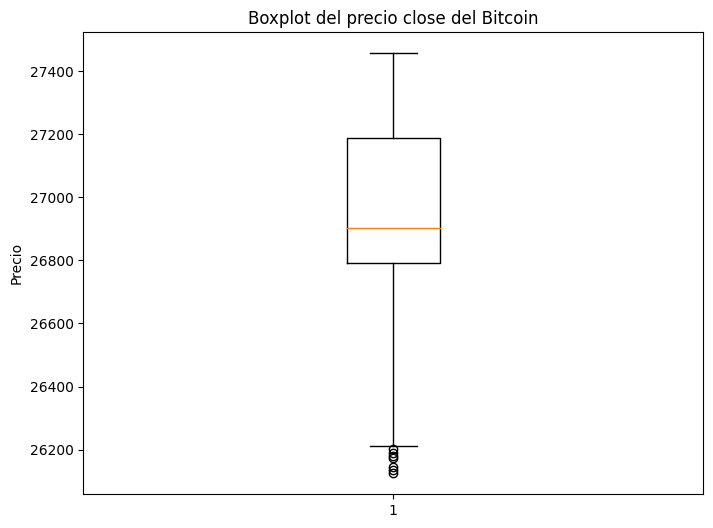

26949.86455004143

In [16]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin_limpio = df_bitcoin.copy()
  
  #INDICES UNICOSS
  indices_duplicados = df_bitcoin_limpio.index.duplicated()
  df_bitcoin_limpio = df_bitcoin_limpio[~indices_duplicados]
    
  #CONVERTIR VALORES NULOS "CIERRE" EN 0
  df_bitcoin_limpio['Close'].fillna(0, inplace=True)
    
  #"VOLUMEN" MAYOR A 0
  if not (df_bitcoin_limpio['Volume'] > 0).all():
      df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
    
  #GRAFICO BOXPLOT
  plt.figure(figsize=(8, 6))
  plt.boxplot(df_bitcoin_limpio["Close"])
  plt.title("Boxplot del precio close del Bitcoin")
  plt.ylabel("Precio")
  plt.show()
    
 #IDENTIFICAR LOS OUTLIERS
  q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  iqr = q3 - q1
  outliers = df_bitcoin_limpio[
      (df_bitcoin_limpio['Close'] < (q1 - 1.5 * iqr)) |
       (df_bitcoin_limpio['Close'] > (q3 + 1.5 * iqr))]

  # ELIMINAR LOS OUTLIERS DE "CIERRE "
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.isin(outliers)].dropna()

  #FILTRO "CIERRE" ENTRE Q1 Y Q3
  df_bitcoin_limpio = df_bitcoin_limpio[
      (df_bitcoin_limpio['Close'] >= q1) & 
       (df_bitcoin_limpio['Close'] <= q3)]

  #CALCULO PRONEDIO "CIERRE"
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

limpieza_datos()
media_bitcoin

# TOMAR DECISIONES 4#

Crear funcion tomar_decisiones

In [17]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  if (precio_actual >= media_bitcoin) and (tendencia == 'Baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) and (tendencia == 'Alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Sin comentarios'

def tomar_decisiones_two():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  decision_two 
  if precio_actual < media_bitcoin and tendencia == "Alta":
    if precio_actual < df_bitcoin['Close'].min():
        decision_two = "comprar con urgencia"
    else:
        decision = "comprar"
  elif precio_actual > media_bitcoin and tendencia == "Baja":
      if precio_actual > df_bitcoin['Close'].max():
          decision_two = "vender con urgencia"
      else:
          decision_two = "evitar"
  else:
      decision_two = "mantener"

tomar_decisiones()
tomar_decisiones_two()
print(algoritmo_decision, decision_two)

Sin comentarios mantener


# VISUALIZACION 5#

crear funcion visualizacion

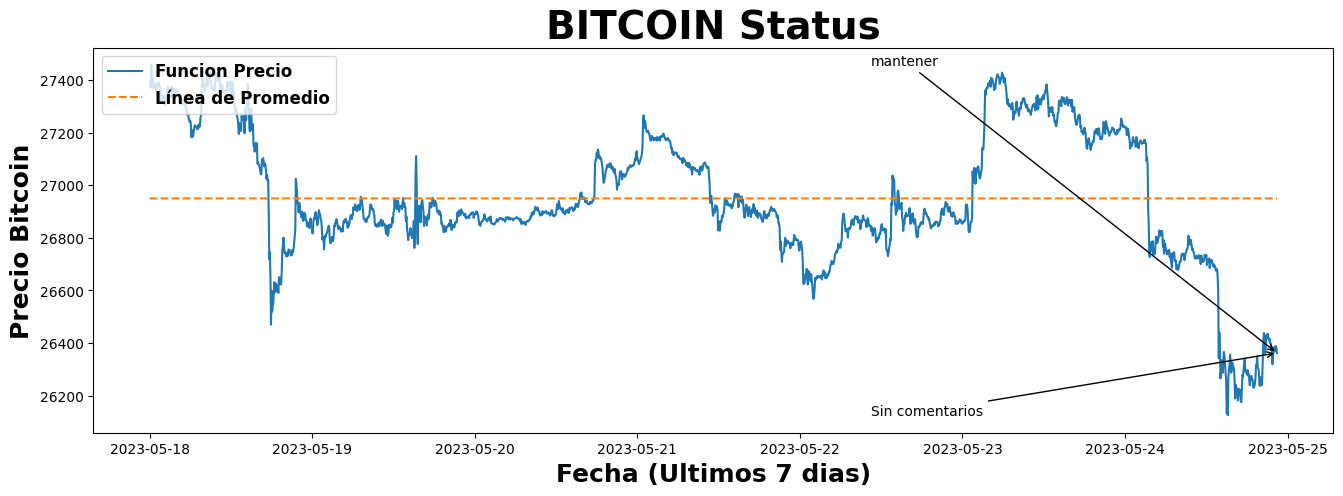

In [18]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision 
  df_bitcoin['Promedio'] = media_bitcoin #Adicionar columna Promedio
  fig = plt.figure(figsize=(16, 5)) #Tamaño grafico
  ax = fig.add_subplot(1, 1, 1) 
  ax.set_title("BITCOIN Status", fontsize=28, fontweight='bold') #Titulo Grafico
  ax.set_xlabel('Fecha (Ultimos 7 dias)', fontsize=18, fontweight='bold')
  ax.set_ylabel('Precio Bitcoin', fontsize=18, fontweight='bold')
  ax.plot(df_bitcoin.index, 
          df_bitcoin["Close"], 
          label='Funcion Precio') # Funcion de Close
  ax.plot(df_bitcoin.index, 
          df_bitcoin["Promedio"], 
          linestyle='--', 
          label='Línea de Promedio') # Funcion de Promedio
  ax.legend(loc='upper left', prop={'size': 12, 'weight': 'bold'})
  plt.annotate(algoritmo_decision, 
               xy=(df_bitcoin.index[-1], df_bitcoin["Close"][-1]), 
               xytext=(df_bitcoin.index[-720], df_bitcoin["Close"].min()),
               arrowprops=dict(facecolor='black', arrowstyle='->')) #Mostrar Mensaje
  plt.annotate(decision_two, 
               xy=(df_bitcoin.index[-1], df_bitcoin["Close"][-1]), 
               xytext=(df_bitcoin.index[-720], df_bitcoin["Close"].max()),
               arrowprops=dict(facecolor='black', arrowstyle='->')) #Mostrar Mensaje two
  plt.show()# Mostrar el gráfico

visualizacion()

#6. AUTOMATIZACION

###6.1. Loop

0.17


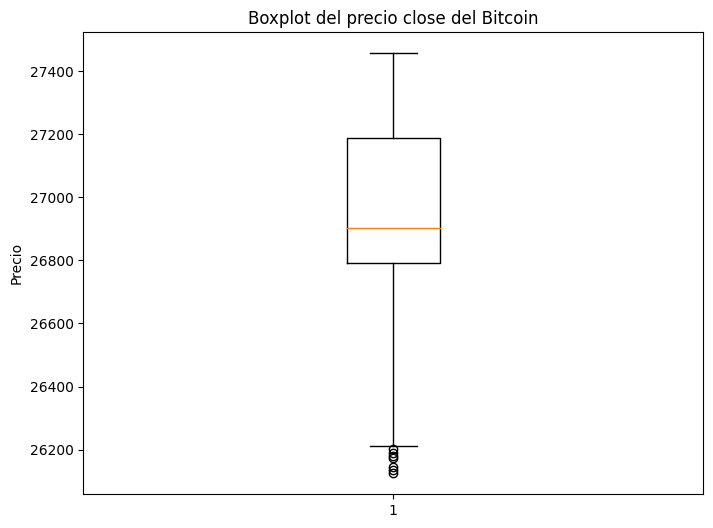

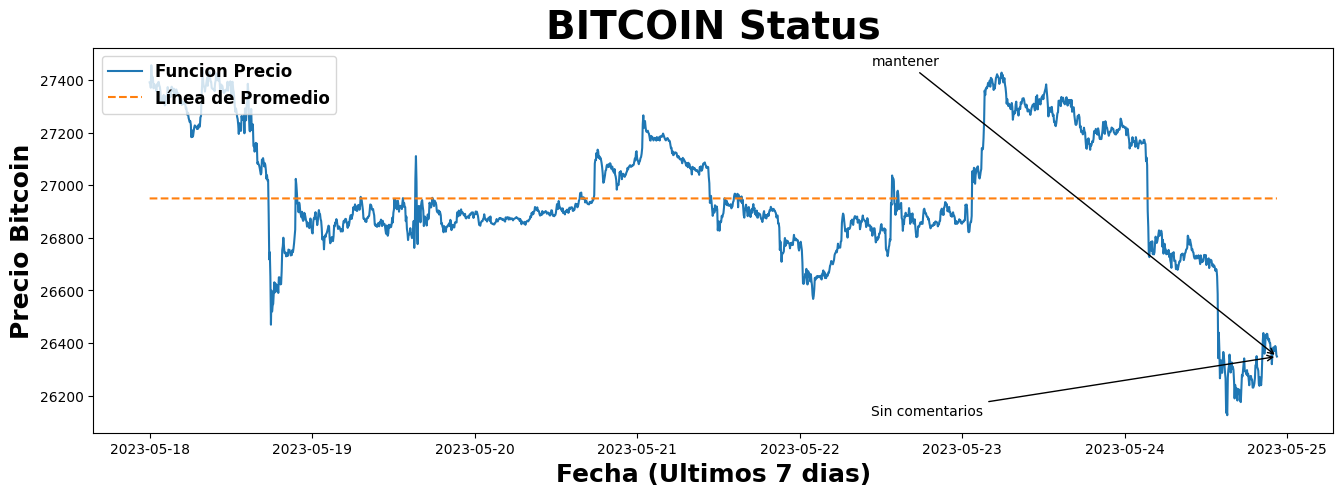

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(10)